In [ ]:
# checkpoint 10/27/18 
#  SINGLE SOMA works with Ina Ik Ica chi is the old version.
#  Icoup = 0.

In [1]:
from brian2 import *
from numpy import matlib
import numpy as np


In [95]:
start_scope()


# FUNCTION SECTION
zetap = 30.  # This is 40 in Poirazi paper
tempc = 23.*kelvin

ca = 2. # ca_out, unitless

xx = 0.0853*(273.16 + tempc/kelvin)/2  # kelvin
tadj = 2.3**((tempc/kelvin-23)/10)   
q = 96480/(8.315*(273.16+tempc/kelvin))  
qt = 5**((tempc/kelvin-24)/10)  

qma = 0.000480*(1/ms)
qmb = 0.280000*(1/ms)
qhat = 1.



@implementation('cython',"""
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
""")
@check_units(v=1, result=1)
def zeta(v):
    return -1.5-(1./(1.+exp((v+30.)/5.))) 
# zeta.stateless = True

@implementation('cython',"""
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  
""")
@check_units(v=1, result=1)
def zeta2(v):
    return -1.8-(1/(1+exp((v+40)/5)))  


@implementation('numpy',discard_units=True)
@check_units(z=1, result=1)  # z is volt, so when used should do eff(z/mV). see ghk(volt)
def eff(z):
    return (1-z/2)*np.heaviside(0.0001-abs(z), 1)+(z/(exp(z)-1))*np.heaviside(abs(z)-0.0001, 1)  


@implementation('cython',"""
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1) 
""")
@check_units(v=1, result=1)
def salfa(v):
    return -0.055*(v+27.01)/(exp((-v-27.01)/3.8)-1)  


@implementation('cython',"""
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 
""")
@check_units(v=1, result=1)
def sbeta(v):
    return 0.94*exp((-v-63.01)/17) 



t_st = 10*ms
# impulse_duration = period*1.1  # 1.25*ms
impulse_str = 62.5*uamp*cm**-2
period = 30*ms

@implementation('numpy',discard_units=True)
@check_units(t=ms, result=1)
def fpost(t):
    return (np.heaviside((t-t_st)/ms,0)*np.heaviside(sin(2*pi*(t-t_st-period)/period),1)\
            *(1 - np.heaviside(sin(2*pi*(t-t_st-period-1*ms)/period),1)))

@implementation('numpy',discard_units=True)
@check_units(t=ms, result=1)
def fpre(t):
    return np.heaviside(np.heaviside((t-t_st)/ms,0) * \
                        np.heaviside(sin(2*pi*(t-t_st-period)/period),1)\
                        *(1 - np.heaviside(sin(2*pi*(t-t_st-period-1*ms)/period),1)))

# (np.heaviside((t-t_st)/ms,0)*np.heaviside(sin(2*pi*(t-t_st-period)/period),1)\
#             *(1 - np.heaviside(sin(2*pi*(t-t_st-period-1*ms)/period),1)))



# fpre(t)=synapse*heav(heav(t-1)*(heav(sin(6.2831853*(t-st-1.1)/period))*(1-heav(sin(6.2831853*(t-st-1)/period))))) +ror*synapse*heav(heav(t-1)*(heav(sin(6.2831853*(t-win-st-1.1)/period))*(1-heav(sin(6.2831853*(t-win-st-1)/period)))))  
# fpost(t)= heav(t-1)*(heav(sin(6.2831853*(t-2-st-delta)/period))*(1-heav(sin(6.2831853*(t-1-st-delta)/period)))) +oro*heav(t-1)*(heav(sin(6.2831853*(t-2-st-delta+win)/period))*(1-heav(sin(6.2831853*(t-1-st-delta+win)/period))))  

In [96]:
# ----- SOMA ------ #

Nsoma = 1

# some calcium-related vars, table 2
pHC = 4.0*umolar
aHC = 0.6*umolar
pHN = 4.
aHN = 3.
alphav = 1.
alphab = 5.
alphad = 1.
thetav = 2.*umolar
thetad = 2.6
thetab = 0.55
Cp = 5.
Cd = 4.
taup = 500*ms
taua = 5*ms
tauv = 10*ms
taud = 250*ms
taub = 40*ms
sigmav = -0.05*umolar
sigmad = -0.01
sigmab = -0.02
p = 0.3
d = 0.01
kd = -0.002
kp = -0.1

# some calcium-related vars, concentration
phisoma = 0.01*umolar/ms/(uamp*cm**-2)
betasoma = 0.083/ms
chi0soma = 0.05*umolar

phispin = 0.01*umolar/ms/(uamp*cm**-2)
betaspin = 0.083/ms
chi0spin = 0.07*umolar
nonc =  6.*umolar





# Ileak
glsoma = 0.1*msiemens/cm**2
glspin = 0.1*msiemens/cm**2

# Ina
gNasoma = 30.*msiemens/cm**2
ENa = 60*mV
gNaSpin = 7.*msiemens/cm**2
natt = 1.
asap=0.001
inact=72.
inact2=0.11
inact3=2.
inact4=64.
inact5=1.

# Ik; Iksoma = kdr + a + mahp; Ikspin = kdr + a
gkdrsoma = 14*msiemens/cm**2
gasoma = 7.5*msiemens/cm**2
gmahpsoma = 25*msiemens/cm**2
Ek = -80*mV
btaumod = 7.
gkdrspin = 0.867*msiemens/cm**2
gaspin = 12.*msiemens/cm**2


# Ica
gcalsoma = 7.0*uamp*cm**-2
gcalspin = 25.0*uamp*cm**-2
Eca = 140.*mV
s1=0.0*ms 
s2=40.*ms 
s3=3.6*ms 

# synapses strength
gnmda = 0.3*uamp*cm**-2
gcanmda = 25.*uamp*cm**-2
gampa = 0.5*uamp*cm**-2
gcoup = 1.125*msiemens/cm**2
allowampa = 1.0
vsynrev = 0.0
speedup =20.
nmdarate = 2.
ndf = 10.0
nds = 45.0   
block = 0.062
blockca =0.124


# Iin
ginsoma = 1*amp*meter**-2

eqs_soma = '''
dv/dt = ( ( Ileak +  Ina + Ik + Ica + Icoup + Iin))/Cme : volt


Ileak = glsoma * (El-v) : amp*meter**-2


Ina = gNasoma * mna**2 * hna * (ENa-v) : amp*meter**-2
# soma activation
alphams = 0.32*(-46.9-v/mV)/(exp((-46.9-v/mV)/4.0)-1.0)/ms :Hz
betams = 0.28*(v/mV+19.9)/(exp((v/mV+19.9)/5.0)-1.0)/ms :Hz
mna = alphams/(alphams+betams) : 1
dhna/dt=alphahs-(alphahs+betahs)*hna  :1
alphahs = 0.128*exp((-43.0-v/mV)/18.0)/ms :Hz
betahs = 4.0/(1.0+exp((-20.0-v/mV)/5.0))/ms :Hz



Ik = Ia + Ikdr + Imahp : amp*meter**-2

Ikdr = gkdrsoma * n_soma * (Ek - v) : amp*meter**-2
dn_soma/dt = alphans-(alphans+betans)*n_soma : 1 
alphans =  0.016*(-24.9-v/mV)/(exp((-24.9-v/mV)/5.0)-1.0)/ms : Hz  
betans =   0.25*exp(-1.0-0.025*v/mV)/ms  : Hz

Ia = gasoma * a_soma * b_soma * (Ek-v) : amp*meter**-2
da_soma/dt=(a_somainf-a_soma)/(a_somatau)  : 1
a_somainf=1/(1+a_smaalf)  : 1
a_smaalf=exp(0.001*zeta(v/mV)*(v/mV-11)*q)  : 1
a_smabet=exp(0.00055*q*(v/mV-11)*zeta(v/mV)) : 1
a_somatau=clip(a_smabet/((1+a_smaalf)*qt*0.05),0.1, inf)*ms : second
db_soma/dt=(b_somainf-b_soma)/(b_somatau) :1
b_somainf = 0.3+0.7/(1+exp(0.02*(v/mV+63.5)*q)) :1   
b_somatau = btaumod*clip(0.11*(v/mV+62),2,inf)*ms : second

Imahp = gmahpsoma * qm_soma * (Ek - v) : amp*meter**-2
dqm_soma/dt = (qm_smainf-qm_soma)/(qm_smatau)  :1
qm_smainf = qhat*qm_smaalf*qm_smatau  : 1
qm_smaalf = qma*chi/umolar/(0.001*chi/umolar + 0.18*exp(-1.68*v/mV*q)) : Hz 
qm_smabet = (qmb*exp(-0.022*v/mV*q))/(exp(-0.022*v/mV*q)+0.001*chi/umolar) : Hz  
qm_smatau = 1/(qm_smaalf+qm_smabet)  : second



Ica = -gcalsoma*s_soma*ghk*(1/(1+chi/umolar)) : amp*meter**-2
ghk = -xx*(1-((chi/umolar/ca)*exp(v/mV/xx)))*eff(v/mV/xx) :1
ds_soma/dt=(s_somainf-s_soma)/(s_somatau)  : 1
s_somainf=salfa(v/mV)/(salfa(v/mV)+sbeta(v/mV))  : 1
s_somatau=1/(5*(salfa(v/mV)+sbeta(v/mV)))*ms  : second

dchi/dt = phisoma*Ica - betasoma*(chi-chi0soma) + chicoup - (betasoma/nonc)*chi**2 : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1
# chicoup  : mmolar/second

Iin = ginsoma * fpost(t) :amp*meter**-2
'''




somas = NeuronGroup(Nsoma, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
somas.v = -60*mV
somas.chi = 0.05*umolar

Msoma = StateMonitor(somas, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)



In [97]:
# ----- SPINE -----#

Nspin = 1


eqs_spin = '''
dv/dt = ( ( Ileak +  Ina + Ik + Ica + Icoup + Iampa + Inmda))/Cme : volt


Ileak = glspin * (El-v) : amp*meter**-2


Ina = gNaspin * mna**2 * hna * ina * (ENa-v) : amp*meter**-2
# soma activation
dm_spin/dt=(m_spininf-m_spin)/(m_spintau) :1
m_spininf=1/(1+exp((-v/mV-40)/3))  : 1
#m_spintau = max(0.1,0.05)   ???
m_spintau = 0.1*ms : second
dh_spin/dt=(h_spininf-h_spin)/(h_spintau)  :1
h_spininf=1/(1+exp((v/mV +45)/3))  :1
h_spintau=0.5*ms : second
di_spin/dt=(i_spininf-i_spin)/(i_spintau)  :1
i_spininf=(1+natt*exp((v/mV+60)/2))/(1+exp((v/mV+60)/2))  :1
i_spintau=clip((0.00333*exp(0.0024*(vspin+60)*q))/(1+exp(0.0012*(vspin+60)*q)),0.1,inf)*ms : second  


Ik = Ia + Ikdr : amp*meter**-2

Ikdr = gkdrspin * n_soma**2 * (Ek - v) : amp*meter**-2
dn_spin/dt=(n_spininf-n_spin)/(n_spintau)  :1
n_spininf=1/(1+exp((-v/mV-42)/2))  :1
n_spintau=2.2*ms : second

Ia = gaspin * a_spin * b_spin * (Ek-v) : amp*meter**-2
da_spin/dt=(a_spininf-a_spin)/(a_spintau)  :1
a_spininf=1/(1+a_spnalf)  :1
a_spnalf=exp(asap*zeta(v/mV)*(v/mV+1)*q)  :1
a_spnbet=exp(0.00039*q*(v/mV+1)*zeta2(v/mV))  :1
a_spintau= clip(a_spnbet/((1+a_spnalf)*qt*0.1),0.1,inf)*ms :second
db_spin/dt=(b_spininf-b_spin)/(b_spintau) :1
b_spininf= 0.3+0.7/(1+exp(inact2*(v/mV+inact)*q)) :1
b_spintau=btaumod*clip(inact3*(v/mV+inact4),inact5, inf)*ms : second


Ica = gcalspin * s_spin**3 * t_spin * (Eca - v)  : amp*meter**-2
ds_spin/dt=(s_spininf-s_spin)/(s_spintau)  :1
s_spininf=1/(1+exp(-v/mV-37))  :1
s_spintau=s3+s1/(1+exp(v/mV+s2))  : second
dt_spin/dt=(t_spininf-t_spin)/(t_spintau)  :1
t_spininf=1/(1+exp((v/mV+41)/.5))  :1
t_spintau=29*ms : second


Iampa = allowampa*gampa*sampa*(vsynrev - v)  : amp*meter**-2
sampa = sampafast+sampaslow+samparise  : 1
dsamparise/dt = -speedup*(1-sampafast-sampaslow)*fpre(t)-(1/0.58)*samparise  :1
dsampafast/dt = speedup*(0.903-sampafast)*fpre(t)-(1/7.6)*sampafast  :1
dsampaslow/dt = speedup*(0.097-sampaslow)*fpre(t)-(1/25.69)*sampaslow  :1



inmda = gnmda*snmda*mnmda*(vsynrev - v)   : amp*meter**-2
icanmda = gcanmda*snmda*mcanmda*(vsynrev - v)   : amp*meter**-2
snmda = snmdafast+snmdaslow+snmdarise
dsnmdarise/dt = -speedup*(1-snmdafast-snmdaslow)*fpre(t)-(1/nmdarate)*snmdarise  :1
dsnmdafast/dt = speedup*(0.527-snmdafast)*fpre(t)-(1/ndf)*snmdafast  :1
dsnmdaslow/dt = speedup*(0.473-snmdaslow)*fpre(t)-(1/nds)*snmdaslow  :1
mnmda=    1/(1.0+0.3*mg*exp(-block*v/mV))  :1
mcanmda=  1/(1.0+0.3*mg*exp(-blockca*v/mV))  :1



dchi/dt = phispin*(Ica+Icanmda) - betaspin*(chi-chi0spin) -(betaspin/nonc)*chi**2 : mmolar
dP/dt = ((10*(chi/pHC)**pHN / (1+(chi/pHC)**pHN))-Cp*A*P)/taup : 1
dA/dt = (((chi/aHC)**aHN/(1+(chi/aHC)**aHN))-A)/taua : 1
dV/dt = ( alphav/(1+exp((chi-thetav)/sigmav)) -V)/tauv : 1
dB/dt = ( alphab/(1+exp((A-thetab)/sigmab)) -B -Cd*V*B)/taub : 1
dD/dt = ( alphad/(1+exp((B-thetad)/sigmad)) -D)/taud : 1

Iin = ginsoma * fpost(t) :amp*meter**-2
'''




spines = NeuronGroup(Nsoma, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')
spines.v = -60*mV
spines.chi = 0.05*umolar

Mspines = StateMonitor(spines, {'v','chi', 'Iin','Ina','Ik','Ica'} , record=True)



In [98]:
# ----- SYNAPSES------ #
# Coupling
eqs_coup = '''
Icoup = gcoup * (v_pre - v_post) : amp*meter**-2 
'''

C_coup_smsp = Synapses(somas, spines, model=eqs_coup, method='rk4')
C_coup_smsp.connect(condition='i == j')
C_coup_spsm = Synapses(spines, somas, model=eqs_coup, method='rk4')
C_coup_spsm.connect(condition='i == j')


CaTauSoSp =1000.*ms
eqs_chi_coup = '''
chicoup = (chi_pre - chi_post)/CaTauSoSp  : mmolar/second
'''
C_chi_coup = Synapses(spines, somas, model=eqs_chi_coup, method='rk4')
C_chi_coup.connect(condition='i == j')

In [99]:
duration = 20*ms
run(duration,report='stdout')

BrianObjectException: Original error and traceback:
Traceback (most recent call last):
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/core/network.py", line 841, in before_run
    obj.before_run(run_namespace)
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/groups/neurongroup.py", line 806, in before_run
    self.equations.check_units(self, run_namespace=run_namespace)
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/equations/equations.py", line 945, in check_units
    user_identifiers=external)  # all variables are user defined
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/groups/group.py", line 739, in resolve_all
    run_namespace=run_namespace)
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/groups/group.py", line 696, in _resolve
    return self._resolve_external(identifier, run_namespace=run_namespace)
  File "/anaconda3/envs/my-brian2-env/lib/python3.6/site-packages/brian2/groups/group.py", line 807, in _resolve_external
    (identifier))
KeyError: 'The identifier "chicoup" could not be resolved.'

Error encountered with object named "neurongroup_24".
Object was created here (most recent call only, full details in debug log):
  File "<ipython-input-96-829a480d42ff>", line 161, in <module>
    somas = NeuronGroup(Nsoma, eqs_soma, threshold='v>0*mV',refractory='v > 0*mV',method='rk4')

An error occurred when preparing an object. KeyError: 'The identifier "chicoup" could not be resolved.'
(See above for original error message and traceback.)

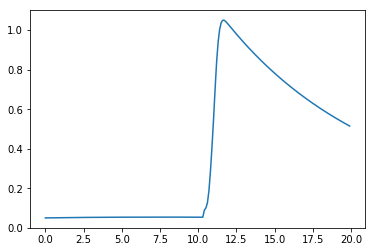

In [64]:
# plot(Msoma.t/ms,Msoma[0].chi/umolar)
# plot(Msoma.t/ms,Msoma[0].v/mV)
# plot(Msoma.t/ms,Msoma[0].Iin/amp)
# plot(Msoma.t/ms,Msoma[0].Ica/mV)


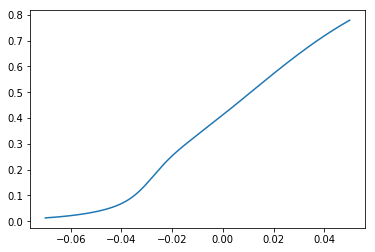

In [59]:
v= linspace(-70,50,1001)*mV
fv = exp(0.00055*q*(v/mV-11)*zeta(v))
#fv = 0.016*(-24.9-v/mV)/(exp((-24.9-v/mV)/5.0)-1.0)
fv2 = 1/(1+fv)
plot(v,fv2)

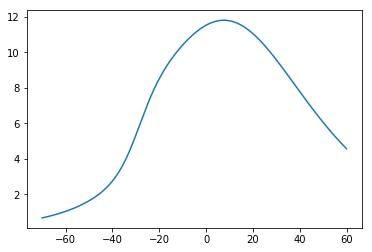

In [108]:
v= linspace(-70,60,1001)*mV
fv1=exp(0.001*zeta(v)*(v/mV-11)*q)  
fv2=exp(0.00055*q*(v/mV-11)*zeta(v))
# dfv=(fvinf-a_soma)/(a_somatau) 
zetav = zeta(v)
fvinf=1/(1+fv1) 
fvtau=np.maximum(fv2/((1+fv1)*qt*0.05),0.1*np.ones(1001))
plot(v/mV,fvtau)
# xlim(-60,-40)
# ylim(0,0.01)

In [67]:
fv2/((1+fv1)*qt*0.05)-0.1*np.ones(1001)

array([0.56142975, 0.56494181, 0.56847265, ..., 5.98774474, 5.96814279,
       5.94857873])

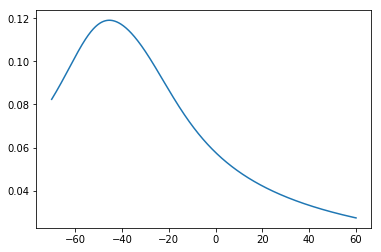

In [107]:
v= linspace(-70,60,1001)*mV

alpham = (0.32/mV) * (v+54*mV) / (-exp((-v-54*mV) / (4*mV)) + 1) 
betam = (0.28/mV) * (v+27*mV)/ (exp((v+27*mV)/(5*mV)) - 1)
taum = 1/(alpham+betam)
minf = alpham*taum

plot(v/mV,taum)

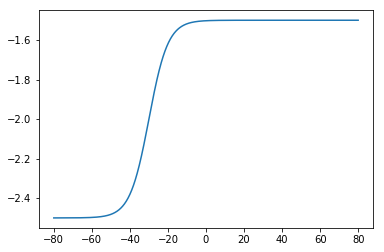

In [8]:
v= linspace(-80,80,1001)*mV


zetav = zeta(v/mV)
plot(v/mV,zetav)

In [25]:
np.heaviside(1,1)

1.0